# Exploratory Data Analysis of AllenSDK

In [1]:
# Only for Colab
#!python -m pip install --upgrade pip
#!pip install allensdk

## References

- [[AllenNB1]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_ophys_data_access.html) Download data using the AllenSDK or directly from our Amazon S3 bucket
- [[AllenNB2]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_ophys_dataset_manifest.html) Identify experiments of interest using the dataset manifest
- [[AllenNB3]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_load_ophys_data.html) Load and visualize data from a 2-photon imaging experiment
- [[AllenNB4]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_mouse_history.html) Examine the full training history of one mouse
- [[AllenNB5]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_compare_across_trial_types.html) Compare behavior and neural activity across different trial types in the task

## Imports

Import and setup Python packages. You should not need to touch this section.

In [2]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# import mindscope_utilities
# import mindscope_utilities.visual_behavior_ophys as ophys

/home/seungjaeryanlee/anaconda3/envs/nma-cn/lib/python3.8/site-packages/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
np.random.seed(42)

## Setup AllenSDK

Configure AllenSDK to get `cache`, `sessions_df` and `experiments_df`. Data will be stored in `./allensdk_storage` by default.

In [4]:
!mkdir -p allensdk_storage
DATA_STORAGE_DIRECTORY = Path("./allensdk_storage")

In [5]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=DATA_STORAGE_DIRECTORY)

The data manifest is comprised of three types of tables:

1. `behavior_session_table`
2. `ophys_session_table`
3. `ophys_experiment_table`

The` behavior_session_table` contains metadata for every **behavior session** in the dataset. Some behavior sessions have 2-photon data associated with them, while others took place during training in the behavior facility. The different training stages that mice are progressed through are described by the session_type.

The `ophys_session_table` contains metadata for every 2-photon imaging (aka optical physiology, or ophys) session in the dataset, associated with a unique `ophys_session_id`. An **ophys session** is one continuous recording session under the microscope, and can contain different numbers of imaging planes (aka experiments) depending on which microscope was used. For Scientifica sessions, there will only be one experiment (aka imaging plane) per session. For Multiscope sessions, there can be up to eight imaging planes per session. Quality Control (QC) is performed on each individual imaging plane within a session, so each can fail QC independent of the others. This means that a Multiscope session may not have exactly eight experiments (imaging planes).

The `ophys_experiment_table` contains metadata for every **ophys experiment** in the dataset, which corresponds to a single imaging plane recorded in a single session, and associated with a unique `ophys_experiment_id`. A key part of our experimental design is targeting a given population of neurons, contained in one imaging plane, across multiple `session_types` (further described below) to examine the impact of varying sensory and behavioral conditions on single cell responses. The collection of all imaging sessions for a given imaging plane is referred to as an **ophys container**, associated with a unique `ophys_container_id`. Each ophys container may contain different numbers of sessions, depending on which experiments passed QC, and how many retakes occured (when a given session_type fails QC on the first try, an attempt is made to re-acquire the `session_type` on a different recording day - this is called a retake, also described further below).

*Text copied from [[AllenNB2]](#References)*

---

We will just use the `ophys_experiment_table`.

In [6]:
experiments_df = cache.get_ophys_experiment_table()

## Specify Experiment

There are a lot of experiments in the table. Let's choose a particular experiment that meet the following criteria:
- Excitatory cells with fast reporter
- Single-plane imaging

### Cre Line and Reporter Line

<img style="width: 50%" src="https://github.com/seungjaeryanlee/nma-cn-project/blob/main/images/cre_lines.png?raw=1">

 The `cre_line` determines which genetically identified neuron type will be labeled by the reporter_line.
 
 This dataset have 3 `cre_line`:
 - **Slc17a7-IRES2-Cre**, which labels excitatory neurons across all cortical layers
 - **Sst-IRES-Cre** which labels somatostatin expressing inhibitory interneurons
 - **Vip-IRES-Cre**, which labels vasoactive intestinal peptide expressing inhibitory interneurons
 
*Text copied from [[AllenNB2]](#References)*

In [7]:
experiments_df["cre_line"].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

There are also 3 `reporter_line`:
 - **Ai93(TITL-GCaMP6f)**, which expresses the genetically encoded calcium indicator GCaMP6f (f is for 'fast', this reporter has fast offset kinetics, but is only moderately sensitive to calcium relative to other sensors) in cre labeled neurons
 - **Ai94(TITL-GCaMP6s)**, which expresses the indicator GCaMP6s (s is for 'slow', this reporter is very sensitive to calcium but has slow offset kinetics), and
 - **Ai148(TIT2L-GC6f-ICL-tTA2)**, which expresses GCaMP6f using a self-enhancing system to achieve higher expression than other reporter lines (which proved necessary to label inhibitory neurons specifically). 

In [8]:
experiments_df["reporter_line"].unique()

array(['Ai148(TIT2L-GC6f-ICL-tTA2)', 'Ai94(TITL-GCaMP6s)',
       'Ai93(TITL-GCaMP6f)'], dtype=object)

The specific `indicator` expressed by each `reporter_line` also has its own column in the table.

In [9]:
experiments_df["indicator"].unique()

array(['GCaMP6f', 'GCaMP6s'], dtype=object)

`full_genotype` contains information for both cre line and reporter line.

In [10]:
experiments_df["full_genotype"].unique()

array(['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'],
      dtype=object)

---

We are looking at excitatory cells, so we should use `cre_line` of `Slc17a7-IRES2-Cre`. We want the fast one, so we select `Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt`.

In [11]:
FULL_GENOTYPE = "Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt"

### Project Code

<img style="width: 50%" src="https://github.com/seungjaeryanlee/nma-cn-project/blob/main/images/datasets.png?raw=1">

"The distinct groups of mice are referred to as dataset variants and can be identified using the `project_code` column." [[AllenNB2]](#References)

In [12]:
experiments_df["project_code"].unique()

array(['VisualBehaviorMultiscope', 'VisualBehaviorTask1B',
       'VisualBehavior'], dtype=object)

---

We are interested in single-plane imaging, so either `VisualBehavior` or `VisualBehaviorTask1B` works.

In [13]:
# We are looking at single-plane imaging
# "VisualBehavior" or "VisualBehaviorTask1B"
PROJECT_CODE = "VisualBehavior"

### Experiment

<img style="width: 50%" src="https://github.com/seungjaeryanlee/nma-cn-project/blob/main/images/data_structure.png?raw=1">

(Note that we are looking at single-plane imaging, so there is only one row (container) per mouse.)

#### `MOUSE_ID`

"The mouse_id is a 6-digit unique identifier for each experimental animal in the dataset." [[AllenNB2]](#References)

---

We retrieve all mouse that can be used for our experiment and select one mouse.

In [14]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("full_genotype == @FULL_GENOTYPE") \
              ["mouse_id"].unique()

array([450471, 459777, 459773, 447663, 445270, 403491, 456917, 456916,
       425493, 431023, 436662, 440298, 431252, 453913, 412366, 425496,
       445002])

In [15]:
MOUSE_ID = 450471

#### `ACTIVE_SESSION`, `PASSIVE_SESSION`

<img style="width: 50%" src="https://github.com/seungjaeryanlee/nma-cn-project/blob/main/images/experiment_design.png?raw=1">

The session_type for each behavior session indicates the behavioral training stage or 2-photon imaging conditions for that particular session. This determines what stimuli were shown and what task parameters were used.

During the 2-photon imaging portion of the experiment, mice perform the task with the same set of images they saw during training (either image set A or B), as well as an additional novel set of images (whichever of A or B that they did not see during training). This allows evaluation of the impact of different sensory contexts on neural activity - familiarity versus novelty.
 - Sessions with **familiar images** include those starting with `OPHYS_0`, `OPHYS_1`, `OPHYS_2`, and `OPHYS_3`.
 - Sessions with **novel images** include those starting with `OPHYS_4`, `OPHYS_5`, and `OPHYS_6`.

Interleaved between **active behavior sessions** are **passive viewing sessions** where mice are given their daily water ahead of the sesssion (and are thus satiated) and view the stimulus with the lick spout retracted so they are unable to earn water rewards. This allows comparison of neural activity in response to stimuli under different behavioral context - active task engagement and passive viewing without reward. There are two passive sessions:
 - `OPHYS_2_images_A_passive`: passive session with familiar images
 - `OPHYS_5_images_A_passive`: passive session with novel images



*Text copied from [[AllenNB2]](#References)*

---

We check which sessions are available for this particular mouse and select one active and one passive session type. Not all sessions may be availble due to QC.

In [16]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("full_genotype == @FULL_GENOTYPE") \
              .query("mouse_id == @MOUSE_ID") \
              ["session_type"].unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_3_images_A',
       'OPHYS_4_images_B', 'OPHYS_5_images_B_passive', 'OPHYS_6_images_B'],
      dtype=object)

Looks like this mouse has all sessions! Let's select the first one then.

In [17]:
SESSION_TYPE = "OPHYS_1_images_A"

#### `EXPERIMENT_ID`

We retrieve the `ophys_experiment_id` of the session type we chose. We need this ID to get the experiment data.

In [18]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("full_genotype == @FULL_GENOTYPE") \
              .query("mouse_id == @MOUSE_ID") \
              .query("session_type == @SESSION_TYPE")

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,...,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
871155338,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,450471,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,112.0,Slc17a7-IRES2-Cre,GCaMP6f,1.0,...,1,870377774,870592115,869781307,VisualBehavior,175,VISp,2019-05-17 16:04:28.000000,OPHYS_1_images_A,871528315
872433717,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,450471,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,115.0,Slc17a7-IRES2-Cre,GCaMP6f,1.0,...,2,871606557,871808394,869781307,VisualBehavior,175,VISp,2019-05-20 16:27:41.000000,OPHYS_1_images_A,872620896
873156540,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,450471,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,116.0,Slc17a7-IRES2-Cre,GCaMP6f,1.0,...,3,872551435,872626160,869781307,VisualBehavior,175,VISp,2019-05-21 15:36:53.000000,OPHYS_1_images_A,873393031
873972085,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,450471,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,117.0,Slc17a7-IRES2-Cre,GCaMP6f,1.0,...,4,873542787,873695653,869781307,VisualBehavior,175,VISp,2019-05-22 17:50:53.000000,OPHYS_1_images_A,874058209


---

Looks like this mouse went through the same session multiple times! Let's just select the first experiment ID.

In [19]:
EXPERIMENT_ID = 871155338

#### `ACTIVE_EXPERIMENT_ID_CONTROL`, `PASSIVE_EXPERIMENT_ID_CONTROL`

In [20]:
PASSIVE_EXPERIMENT_ID_CONTROL =884218326

## Download Experiment

Download the experiment with the selected `experiment_id`.

We can now download the experiment. Each experiment will be approximately 600MB - 2GB in size.

In [21]:
experiment = cache.get_behavior_ophys_experiment(EXPERIMENT_ID)

In [22]:
experiment

This returns an instance of `BehaviorOphysExperiment`. It contains multiple attributes that we will need to explore.

## Attributes of the Experiment

Explore what information we have about the experiment by checking its attributes.

### `dff_traces`

"`dff_traces` dataframe contains traces for all neurons in this experiment, unaligned to any events in the task." [[AllenNB3]](#References)

In [23]:
experiment.dff_traces.head()

,cell_roi_id,dff
cell_specimen_id,,
1086545833,1080865011,"[0.17061558365821838, 0.4512314200401306, 0.32..."
1086524443,1080865032,"[0.1516352742910385, 0.22091741859912872, 0.10..."
1086511120,1080865099,"[0.18326713144779205, 0.3606158196926117, 0.27..."
1086511673,1080865114,"[0.25259000062942505, 0.20413021743297577, 0.1..."
1086514843,1080865123,"[0.3228359818458557, 0.18583296239376068, 0.23..."


Since `dff` is stored as a list, we need to get timestamps for each of those numbers.

### `ophys_timestamps`

`ophys_timestamps` contains the timestamps of every record.

In [24]:
experiment.ophys_timestamps

array([3.07988000e+00, 3.11219000e+00, 3.14449000e+00, ...,
       4.53288373e+03, 4.53291605e+03, 4.53294837e+03])

Let's do a sanity check by checking the length of both lists.

In [25]:
print(f"dff has length {len(experiment.dff_traces.iloc[0]['dff'])}")
print(f"timestamp has length {len(experiment.ophys_timestamps)}")

dff has length 140164
timestamp has length 140164


### `stimulus_presentations`

We also need timestamps of when stimulus was presented. This information is contained in `stimulus_presentations`.

In [26]:
experiment.stimulus_presentations.head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25018,18002.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17987,305.86494,306.11512,False
1,0.25020,18047.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18032,306.61553,306.86573,False
2,0.25014,18092.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18077,307.36651,307.61665,False
3,0.25000,NaN,8,omitted,omitted,0,True,18121,308.10035,308.35035,False
4,0.25020,18182.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18167,308.86737,309.11757,False


During imaging sessions, stimulus presentations (other than the change and pre-change images) are omitted with a 5% probability, resulting in some inter stimlus intervals appearing as an extended gray screen period. [[AllenNB2]](#References)

<img style="width: 50%" src="https://github.com/seungjaeryanlee/nma-cn-project/blob/main/images/omissions.png?raw=1">

In [27]:
experiment.stimulus_presentations.query("omitted").head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
3,0.25,NaN,8,omitted,omitted,0,True,18121,308.10035,308.35035,False
26,0.25,NaN,8,omitted,omitted,1,True,19156,325.36416,325.61416,False
61,0.25,NaN,8,omitted,omitted,2,True,20731,351.63595,351.88595,False
95,0.25,NaN,8,omitted,omitted,3,True,22261,377.15644,377.40644,False
143,0.25,NaN,8,omitted,omitted,4,True,24421,413.18582,413.43582,False


### `stimulus_templates`

If we want to know what the stimulus looks like, we can check `stimulus_templates`.

In [28]:
experiment.stimulus_templates

,unwarped,warped
image_name,,
im065,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[198, 197, 201, 207, 207, 202, 198, 201, 207,..."
im077,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[129, 135, 140, 142, 140, 135, 129, 124, 117,..."
im066,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[83, 85, 82, 78, 78, 81, 84, 84, 82, 82, 84, ..."
im061,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[125, 126, 126, 126, 125, 125, 125, 125, 125,..."
im063,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[105, 108, 107, 101, 97, 96, 98, 101, 103, 10..."
im062,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[103, 103, 103, 105, 112, 125, 145, 172, 204,..."
im085,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[54, 56, 50, 45, 45, 51, 56, 55, 51, 48, 49, ..."
im069,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[251, 248, 255, 255, 255, 254, 246, 248, 255,..."


We see that we have a matrix for the `warped` column and a stub matrix for the unwarped column. Let's display the `warped` column.

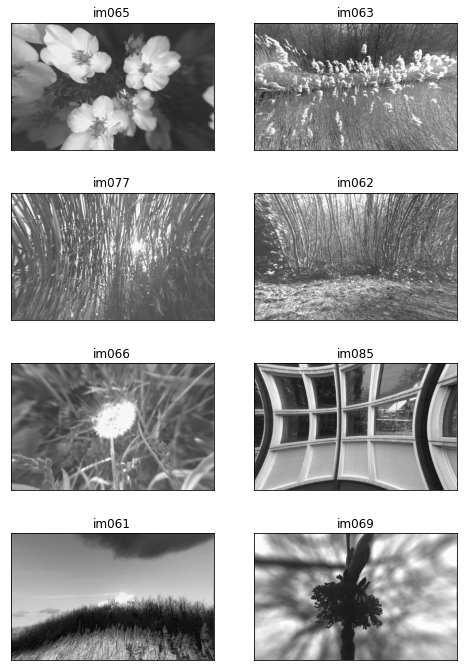

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(8, 12))

for i, image_name in enumerate(experiment.stimulus_templates.index):
    ax[i%4][i//4].imshow(experiment.stimulus_templates.loc[image_name]["warped"], cmap='gray', vmin=0, vmax=255)
    ax[i%4][i//4].set_title(image_name)
    ax[i%4][i//4].get_xaxis().set_visible(False)
    ax[i%4][i//4].get_yaxis().set_visible(False)

fig.show()

So this is what the mouse is seeing! But can we see the original, unwarped image? For that, we need to use another AllenSDK cache that contains these images.

In [30]:
boc = BrainObservatoryCache()
scenes_data_set = boc.get_ophys_experiment_data(501498760)

This data set contains a lot of images in a form of a 3D matrix (`# images` x `width` x `height` ).

In [31]:
scenes = scenes_data_set.get_stimulus_template('natural_scenes')

In [32]:
scenes.shape

(118, 918, 1174)

We just want the images that were shown above. Notice that the indices are part of the name of the images.

In [33]:
experiment.stimulus_templates.index

Index(['im065', 'im077', 'im066', 'im061', 'im063', 'im062', 'im085', 'im069'], dtype='object', name='image_name')

Using this, we can plot the unwarped versions!

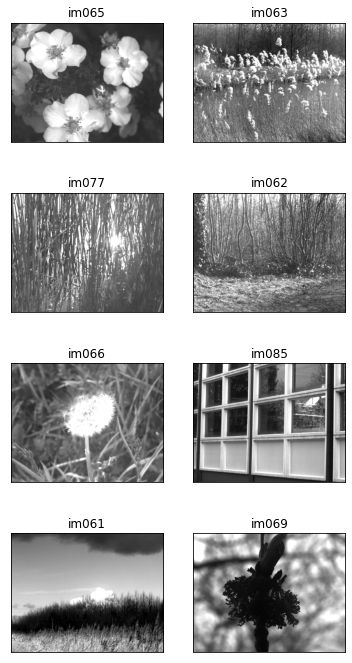

In [34]:
fig, ax = plt.subplots(4, 2, figsize=(6, 12))
for i, image_name in enumerate(experiment.stimulus_templates.index):
    scene_id = int(image_name[2:])

    ax[i%4][i//4].imshow(scenes[scene_id, :, :], cmap='gray', vmin=0, vmax=255)
    ax[i%4][i//4].set_title(image_name)
    ax[i%4][i//4].get_xaxis().set_visible(False)
    ax[i%4][i//4].get_yaxis().set_visible(False)

## Visualization

We do some basic plots from the information we gathered from various attributes.

### Plot dF/F Trace

Let's choose some random `cell_specimen_id` and plots its dff trace for time 400 to 450.

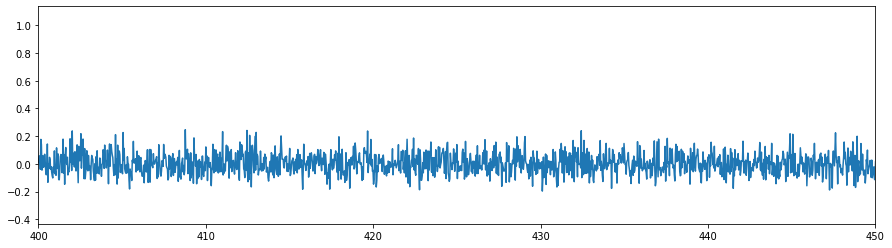

In [35]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(
    experiment.ophys_timestamps,
    experiment.dff_traces.loc[1086545833]["dff"],
)

ax.set_xlim(400, 450)

fig.show()

### Plot Stimulus

Let's also plot stimulus for a short interval.

*Part of code from [[AllenNB3]](#References)*

In [36]:
# Create a color map for each image
unique_stimuli = [stimulus for stimulus in experiment.stimulus_presentations['image_name'].unique()]
colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
# Keep omitted image as white
colormap['omitted'] = (1,1,1)

In [37]:
stimulus_presentations_sample = experiment.stimulus_presentations.query('stop_time >= 400 and start_time <= 450')

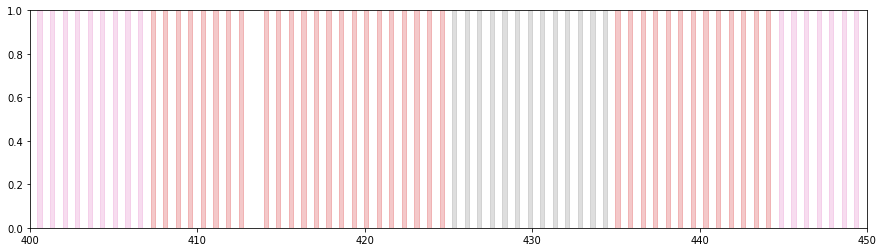

In [38]:
fig, ax = plt.subplots(figsize=(15, 4))

for idx, stimulus in stimulus_presentations_sample.iterrows():
    ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=colormap[stimulus['image_name']], alpha=0.25)

ax.set_xlim(400, 450)
    
fig.show()

### Plot Both dF/F trace and Stimulus

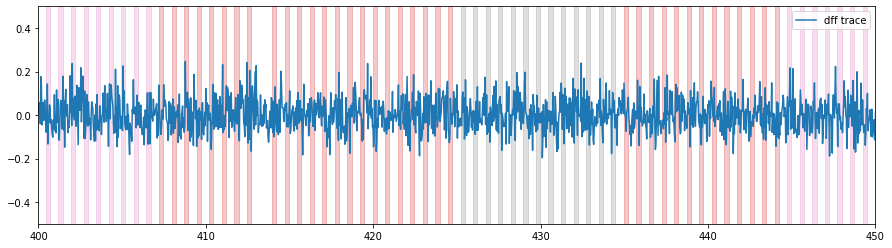

In [39]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(
    experiment.ophys_timestamps,
    experiment.dff_traces.loc[1086545833]["dff"],
)

for idx, stimulus in stimulus_presentations_sample.iterrows():
    ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=colormap[stimulus['image_name']], alpha=0.25)

ax.set_xlim(400, 450)
ax.set_ylim(-0.5, 0.5)
ax.legend(["dff trace"])

fig.show()